In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from xgboost import XGBClassifier as XGBC
import plotly.express as px
from umap import UMAP
from sklearn.manifold import TSNE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from IPython.display import Image, display
import numpy as np

## Initialization

In [2]:
static = pd.read_csv('../data/static.csv')
dynamic = pd.read_csv('../data/dynamic.csv')
notes = pd.read_csv('../data/notes.csv')

print('static')
display(static.head())
print('\ndynamic')
display(dynamic.head())
print('\nnotes')
display(notes.head())

static


,id,hosp_admittime,hosp_dischtime,icu_intime,icu_outtime,los_icu,icu_death,gender,race,admission_age,...,atrial_fibrillation,malignant_cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,stroke
0,24099382,6/11/11 7:15,6/18/11 21:45,6/11/11 14:31,6/13/11 18:05,2.15,0,M,OTHER,58.441631,...,0,0,0,0,0,1,1,1,0,0
1,27824879,9/30/28 20:55,10/10/28 15:54,9/30/28 20:58,10/5/28 18:39,4.90,0,F,WHITE,79.748598,...,0,0,0,0,0,1,0,1,1,0
2,27146619,9/20/41 0:34,9/22/41 12:05,9/20/41 7:13,9/21/41 18:10,1.46,0,F,WHITE,81.717397,...,0,0,1,1,0,0,0,0,1,0
3,22476441,10/8/73 16:46,10/16/73 13:05,10/8/73 18:28,10/10/73 13:26,1.79,0,F,BLACK/AFRICAN AMERICAN,63.769278,...,0,0,1,1,0,1,1,1,1,0
4,23169158,3/12/27 1:19,3/19/27 13:15,3/12/27 2:43,3/15/27 1:53,2.97,0,F,WHITE,84.191979,...,1,0,1,1,0,0,1,1,0,0



dynamic


,id,charttime,albumin,globulin,total_protein,aniongap,bicarbonate,bun,calcium,chloride,...,sodium_bg,lactate_bg,glucose_bg,d_dimer,fibrinogen,thrombin,inr,pt,ptt,urineoutput
0,28793466,4/12/29 3:35,NaN,NaN,NaN,16.0,21.0,12.0,8.8,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.9,27.8,NaN
1,25611175,11/29/40 3:50,NaN,NaN,NaN,15.0,27.0,28.0,8.5,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26115624,9/7/50 0:22,3.5,NaN,NaN,12.0,22.0,9.0,7.9,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.2,13.9,25.8,NaN
3,28164589,3/11/59 1:11,NaN,NaN,NaN,12.0,34.0,58.0,8.3,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.8,41.7,40.2,NaN
4,26115624,9/1/50 20:14,NaN,NaN,NaN,NaN,NaN,11.0,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



notes


,note_id,id,note_type,note_seq,charttime,text
0,10002930-RR-19,25696644,RR,19,4/14/96 9:57,HISTORY: Altered mental status.\n\nTECHNIQUE:...
1,10003046-RR-7,26048429,RR,7,1/2/54 16:29,"INDICATION: Esophageal carcinoma, status post..."
2,10003046-RR-8,26048429,RR,8,1/3/54 7:33,HISTORY: Postop day one interval change.\n\nC...
3,10003400-RR-65,20214994,RR,65,2/24/37 16:01,EXAMINATION: CHEST (PRE-OP PA AND LAT)\n\nIND...
4,10003400-RR-66,20214994,RR,66,2/25/37 19:23,EXAMINATION: ABDOMINAL RADIOGRAPHS\n\nINDICAT...


In [3]:
static_unique_ids = static['id'].nunique()
dynamic_unique_ids = dynamic['id'].nunique()
notes_unique_ids = notes['id'].nunique()


print(f'static ids: {static_unique_ids}')
print(f'dynamic ids: {dynamic_unique_ids}')
print(f'notes ids: {notes_unique_ids}')

static ids: 20414
dynamic ids: 20414
notes ids: 20414


In [4]:
def na_ratio_acceptable(df, column_name, threshold=0.8):
    na_count = df[column_name].isna().sum()

    non_na_ratio = 1 - (na_count / df.shape[0])

    if non_na_ratio >= threshold:
        return True

    else:
        return False

In [5]:
def get_threshold_matrix(df):
    features = df.select_dtypes(include=[np.number]).columns.tolist()
    correlation_matrix = df[features].corr()

    threshold = 0.9
    threshold_matrix = correlation_matrix[abs(correlation_matrix) >= threshold]
    threshold_matrix = threshold_matrix.stack().reset_index().dropna(how='any')

    threshold_matrix.columns = ['variable_1', 'variable_2', 'correlation']
    threshold_matrix = threshold_matrix.sort_values(by='correlation', ascending=False)
    threshold_matrix = threshold_matrix[threshold_matrix.variable_1 != threshold_matrix.variable_2]

    threshold_matrix['sorted_pair'] = threshold_matrix.apply(lambda row: tuple(sorted([row['variable_1'], 
                                                                                    row['variable_2']])), 
                                                            axis=1)

    threshold_matrix = threshold_matrix.drop_duplicates(subset=['sorted_pair']).drop('sorted_pair', axis=1)

    return threshold_matrix


## Static Cleaning

In [6]:
static_acceptable_cols = []

for col in static.columns:
    if na_ratio_acceptable(static, col):
        static_acceptable_cols.append(col)

static_acceptable_cols

['id',
 'hosp_admittime',
 'hosp_dischtime',
 'icu_intime',
 'icu_outtime',
 'los_icu',
 'icu_death',
 'gender',
 'race',
 'admission_age',
 'weight_admit',
 'admission_type',
 'first_careunit',
 'charlson_score',
 'atrial_fibrillation',
 'malignant_cancer',
 'chf',
 'ckd',
 'cld',
 'copd',
 'diabetes',
 'hypertension',
 'ihd',
 'stroke']

In [7]:
static = static[static_acceptable_cols].dropna()
static_unique_ids = static['id'].nunique()
static['gender'] = static['gender'].map(lambda x: 1 if x == 'M' else 0)

print(f'static ids: {static_unique_ids}')

static ids: 19802


In [8]:
get_threshold_matrix(static)

,variable_1,variable_2,correlation


## Dynamic Cleaning

In [9]:
dynamic_acceptable_cols = []

for col in dynamic.columns:
    if na_ratio_acceptable(dynamic, col):
        dynamic_acceptable_cols.append(col)

dynamic_acceptable_cols

['id',
 'charttime',
 'aniongap',
 'bicarbonate',
 'bun',
 'calcium',
 'chloride',
 'creatinine',
 'glucose',
 'sodium',
 'potassium']

In [10]:
dynamic = dynamic[dynamic_acceptable_cols].dropna()
dynamic = dynamic[dynamic['id'].isin(static['id'].unique())]
dynamic_unique_ids = dynamic['id'].nunique()

print(f'dynamic ids: {dynamic_unique_ids}')

dynamic ids: 19200


In [11]:
get_threshold_matrix(dynamic)

,variable_1,variable_2,correlation


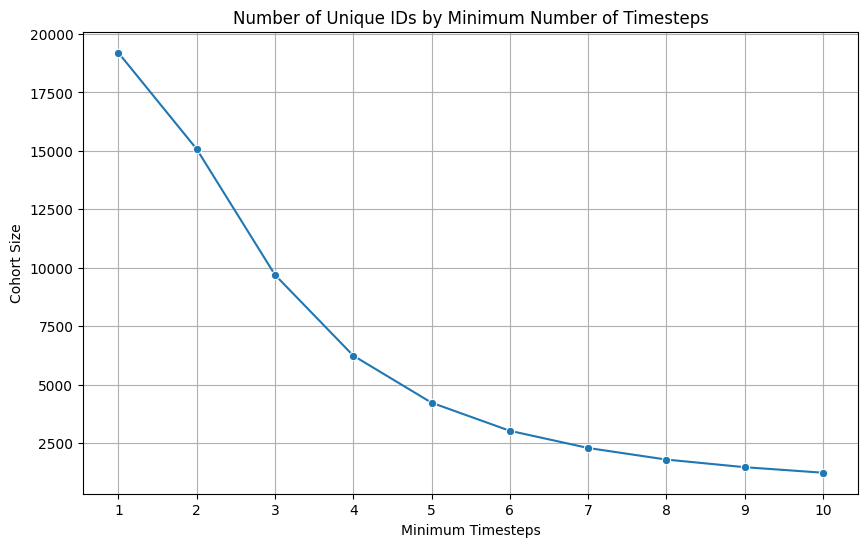

In [12]:
thresholds = range(1, 11)
counts = []

for threshold in thresholds:
    filtered_id_counts = dynamic['id'].value_counts()[dynamic['id'].value_counts() >= threshold]
    counts.append(len(filtered_id_counts))

plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=counts, marker='o')

plt.title('Number of Unique IDs by Minimum Number of Timesteps')
plt.xlabel('Minimum Timesteps')
plt.ylabel('Cohort Size')
plt.xticks(thresholds)
plt.grid(True)
plt.show()

In [13]:
valid_ids = dynamic['id'].value_counts()[dynamic['id'].value_counts() >= 3].index.unique()

dynamic = dynamic[dynamic['id'].isin(valid_ids)]

print(f'dynamic shape: {dynamic.shape}')

print(f'cohort size: {dynamic["id"].nunique()}')

dynamic shape: (59452, 11)
cohort size: 9696


## Notes Cleaning

In [14]:
notes_acceptable_cols = []

for col in notes.columns:
    if na_ratio_acceptable(notes, col):
        notes_acceptable_cols.append(col)

notes_acceptable_cols

['note_id', 'id', 'note_type', 'note_seq', 'charttime', 'text']

In [15]:
notes = notes[notes_acceptable_cols].dropna()
notes_unique_ids = notes['id'].nunique()

print(f'notes ids : {notes_unique_ids}')

notes ids : 20414


In [16]:
notes = notes[notes['id'].isin(valid_ids)]

print(f'notes shape: {notes.shape}')

print(f'cohort size: {notes["id"].nunique()}')

notes shape: (47608, 6)
cohort size: 9696


In [17]:
def calculate_intervals(group):
    last_date = group['charttime'].max()
    group['interval'] = (last_date - group['charttime']).dt.days
    
    return group

In [21]:
notes['charttime'] = pd.to_datetime(notes['charttime'], format='%m/%d/%y %H:%M')
max_charttime = notes.groupby('id')['charttime'].transform('max')

notes['interval'] = (max_charttime - notes['charttime']).dt.days


notes = notes.sort_values(by=['id', 'charttime'], ascending=[False, True])

notes.head(20)

,note_id,id,note_type,note_seq,charttime,text,interval
68719,18434803-RR-10,29998399,RR,10,2012-05-08 18:52:00,INDICATION: ___ rear ended motor cycle into s...,1
68720,18434803-RR-11,29998399,RR,11,2012-05-08 19:09:00,EXAMINATION: CT HEAD W/O CONTRAST\n\nINDICATI...,0
68721,18434803-RR-12,29998399,RR,12,2012-05-08 19:09:00,EXAMINATION: CT C-SPINE W/O CONTRAST\n\nINDIC...,0
68722,18434803-RR-13,29998399,RR,13,2012-05-08 19:10:00,EXAMINATION: CT torso\n\nINDICATION: ___ rea...,0
68723,18434803-RR-14,29998399,RR,14,2012-05-08 19:12:00,EXAMINATION: SCROTAL U.S.\n\nINDICATION: ___...,0
68724,18434803-RR-15,29998399,RR,15,2012-05-08 20:21:00,INDICATION: ___ s/p MCC intubated// plz evalu...,0
68725,18434803-RR-16,29998399,RR,16,2012-05-08 20:41:00,"INDICATION: ___ year old man with open book, ...",0
68726,18434803-RR-17,29998399,RR,17,2012-05-08 21:02:00,INDICATION: ___ year old man with polytrauma ...,0
68727,18434803-RR-18,29998399,RR,18,2012-05-08 23:52:00,EXAMINATION: CT PELVIS WITHOUT CONTRAST\n\nIN...,0
68729,18434803-RR-20,29998399,RR,20,2012-05-09 04:01:00,EXAMINATION: CT HEAD W/O CONTRAST Q111 CT HEA...,0
